In [1]:
import numpy as np #Handle math objects like vectors and matrixs
import scipy as sp
from scipy.stats import norm # Normal cdf is used
import pandas as pd #Contains data from yahoo
import matplotlib.pyplot as plt # Seeing is believing! --Thrall
from datetime import datetime # Very usefull when you need to operate on date
from datetime import timedelta # Very usefull when you need to operate on date
from yahoo_finance import Share # API from Yahoo to fetch data
%matplotlib inline
float_formatter = lambda x: "%.3f" % x if x >=0 else "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.options.display.float_format = '{:20,.3f}'.format

In [2]:
universe = ['SPY','GOOG','AAPL','AMZN','MSFT','IBM','M','MNST','PNC','ROST','COO']

In [3]:
n = len(universe)
i = datetime.now()
j = i - timedelta(days=252*2)
currentDate = "%s-%s-%s"%(i.year,i.month,i.day-1)
startDate = "%s-%s-%s"%(j.year,j.month,j.day)

* M is the dataframe that stores log returns of all the stocks.`

In [4]:
count = 0
for symbol in universe:
    equity = Share(symbol)
    df = pd.DataFrame(equity.get_historical(startDate,currentDate))
    df.index = df.Date
    df.drop('Date',1,inplace = True)
    df.sort_index(inplace = True) # ,ascending = False
    df['Adj_Close'] = pd.to_numeric(df['Adj_Close'])
    label = symbol#+'_logReturn'
    df[label] = np.log(1+df.Adj_Close.diff(1)/df.Adj_Close)
#     df.fillna(0,inplace = True)
    df.dropna(inplace = True)
    
    if count==0:
        M = df[[label]].copy()
    else:
        M = M.join(df[[label]])
    
    count += 1


* Solve the covariance matrix of the stocks ($C=cov(diag[\sigma] B)/t$)

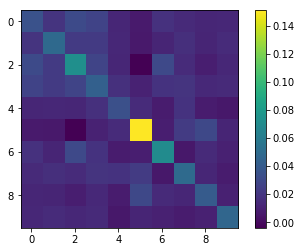

In [7]:
dt = 1/252
set1 = [x for x in universe if x != 'SPY']
covMat = np.cov(M[set1].values.T)
# covMat = np.cov(M.values.T)
C = covMat/dt
# print(C)
plt.imshow(C)
plt.colorbar() 

* Perform Cholesky on C to get $\Sigma$

__$\Sigma = CholeskyDecompose(C)$__

In [8]:
Sigma = np.linalg.cholesky(C)
sigma = np.sum(Sigma**2,axis = 1)**(0.5)
R = np.dot(np.linalg.inv(np.diag(sigma)),Sigma)

* Another way to decompose the covariance matrix is PCA(SVD)

$$C = U \Lambda U^T$$

We will now show that even though $U \Lambda U^T =  \Sigma \Sigma^T$, $U \Lambda^{\frac{1}{2}} \neq \Sigma$

In [9]:
u,s,v = np.linalg.svd(C)
ul = np.dot(u,np.diag(s**0.5))

* In the cell above we can see $U \Lambda^{\frac{1}{2}} (U\Lambda^{\frac{1}{2}})^T= C$.

* Next we compare $U \Lambda^{\frac{1}{2}}$ and $\Sigma$ :

In [10]:
print(ul)
print(Sigma)

[[-0.12 0.085 0.017 -0.00 0.023 -0.02 0.023 0.051 -0.03 -0.08]
 [-0.12 0.077 0.075 -0.04 -0.03 -0.10 -0.09 -0.04 0.007 0.001]
 [-0.15 0.166 -0.03 0.047 0.132 0.003 0.022 -0.04 0.030 0.017]
 [-0.14 0.083 0.041 0.005 -0.01 -0.01 0.012 0.086 -0.06 0.058]
 [-0.10 0.022 0.061 0.049 -0.04 0.040 -0.03 0.064 0.100 -0.00]
 [-0.25 -0.29 -0.03 0.008 0.046 -0.00 -0.02 0.003 -0.01 0.000]
 [-0.13 0.094 -0.19 0.012 -0.08 0.024 -0.04 -0.01 -0.01 -0.00]
 [-0.13 0.011 0.106 0.069 -0.06 0.075 0.013 -0.08 -0.04 -0.01]
 [-0.12 -0.02 -0.01 -0.03 -0.07 -0.07 0.121 -0.02 0.035 0.007]
 [-0.09 0.035 0.021 -0.17 0.014 0.079 0.003 -0.01 0.011 0.002]]
[[0.187 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.104 0.195 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.164 0.028 0.214 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.145 0.038 0.015 0.144 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.068 0.032 0.003 0.042 0.163 0.000 0.000 0.000 0.000 0.000]
 [0.039 0.014 -0.05 0.037 0.064 0.376 0.000 0.000 0.00

***************

## Trump Factor

* Center X and Y

In [12]:
X = M[set1].values-M[set1].mean().values

1. Principal Component Factors：
    
    (1) PCA 分解$X^T X$: $X^{T}X = G S G^{T}$
    
    (2) 此处$G$是幺正矩阵，对$X$进行旋转得到: $Y = XG$
        
    如果只取G的前K列$G_k$: $Y_k = XG_k$ 得到前K个factor $F=Y_k$
    
    (3) 恢复$X$: $\hat{X} = FG_k^T$

In [53]:
# PCA on X^T*X
U,S,G = np.linalg.svd(np.dot(X.T,X))

# Choose number of dimension to keep
dimension = 5

F = np.dot(X,G[:,0:dimension])

X_hat = np.dot(F,G[:,0:dimension].T)

* Loading of n stocks to 5 factors

In [54]:
print(G[:,0:dimension])

[[-0.28 -0.27 -0.33 -0.32 -0.22]
 [0.226 0.205 0.442 0.220 0.057]
 [0.070 0.303 -0.13 0.167 0.248]
 [-0.00 -0.21 0.230 0.022 0.235]
 [0.118 -0.14 0.679 -0.06 -0.21]
 [-0.10 -0.60 0.020 -0.05 0.234]
 [0.138 -0.55 0.135 0.071 -0.16]
 [0.328 -0.28 -0.27 0.552 0.415]
 [-0.25 0.054 0.218 -0.44 0.731]
 [-0.81 0.006 0.165 0.557 -0.04]]


* Plot the eigen vectors in a bar chart

<Container object of 10 artists>

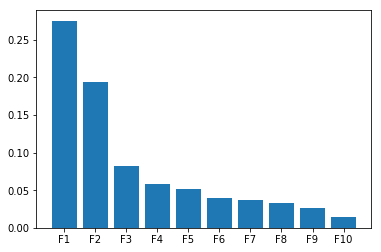

In [55]:
eig_label = ['F'+str(i+1) for i in range(n-1)]
plt.bar(left = range(n-1),height = S,tick_label = eig_label)

* Plot the loading of n stocks to each factor

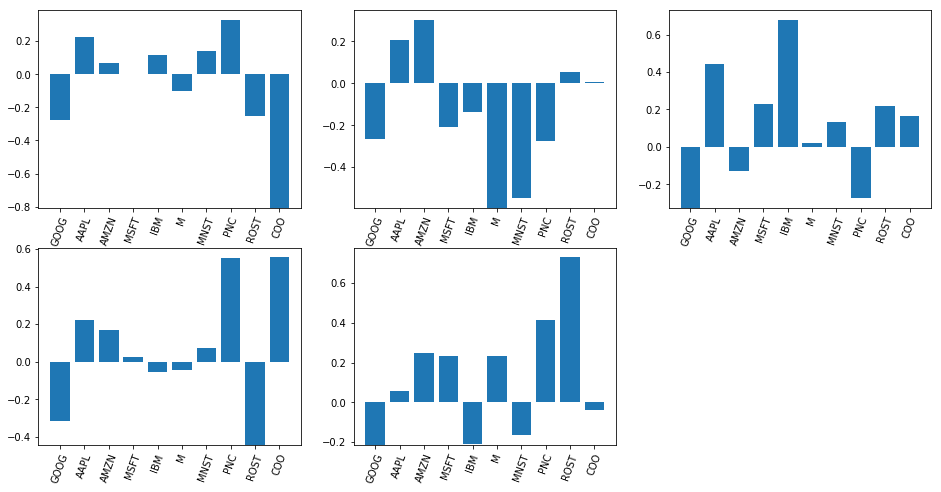

In [56]:
fig = plt.figure(figsize=(16, 8)) 

for j in range(dimension):
    plt.subplot(231+j)
    plt.xticks(rotation=70)
    plt.bar(left = range(n-1),height = G[:,j],tick_label = set1)

Weird, What happened to Google...?